# $D_{s1}(2460)^+\to D_s^+\gamma$ production study
## Yields
### Data analysis
#### MVA Selection: One vs All (OvA) training

Iván Cambón Bouzas

Instituto Galego de Física de Altas Enerxías

Universidade de Santiago de Compostela



In [1]:
import ROOT
from datetime import datetime
import numpy as np
import sys 
import uncertainties as un
import pandas as pd
import os
from particle import Particle
import mplhep
from matplotlib import pyplot as plt
from sklearn.ensemble import  AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import KFold
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
ROOT.EnableImplicitMT()
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyFit')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyShort')
sys.path.append('/home3/ivan.cambon/Python_Modules/RooPyML')
import RooPyFit as rpf
import RooPyShort as rsh
import RooPyML as rml

print(datetime.now())

ROOT.gROOT.ProcessLine(".L lhcbStyle.C")
ROOT.lhcbStyle()

%jsroot on

Welcome to JupyROOT 6.28/04
2024-03-18 10:10:32.355753
-------------------------
Set LHCb Style - May 2021
-------------------------


In [2]:
if not os.path.exists("./Graphs"):
    os.makedirs("./Graphs")
else:
    print("Graphs directory already exists")

if not os.path.exists("./root_files"):
    os.makedirs("./root_files")
else:
    print("root_files directory already exists")

Graphs directory already exists
root_files directory already exists


## RDataFrame definition

### Data

In [3]:
Data_MagD18_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/Data/MagDown/2018'
nfiles = len(os.listdir(Data_MagD18_path))

data_for_train = set(["{0}/DsJ_Data_MagD18_{1}.root".format(Data_MagD18_path, i) for i in range(100, 115)])
  
Data_files = "DsJ_*.root"
dtt = "DsGammaTuple"

tdf_data = ROOT.RDataFrame("{0}/DecayTree".format(dtt), "{0}/{1}".format(Data_MagD18_path, Data_files))
tdf_data = tdf_data.Define("DsgM", "Dsg_M-Ds_M+1969")
  
tdf_data_train = ROOT.RDataFrame("{0}/DecayTree".format(dtt), data_for_train)
tdf_data_train = tdf_data_train.Define("DsgM", "Dsg_M-Ds_M+1969")

### MonteCarlo

In [4]:
priv = False
Filt = True

if priv:
    MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Private/'
else:
    if Filt:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/TightCut/'
    else:
        MC_path = '/scratch42/ivan.cambon/DsJ_Spectroscopy/MC/Official/DecProdCut/'

MC_Ds1_sig_files = "Ds1DsGamma*.root"
MC_Dsst_sig_files = "DsstDsGamma*.root"
dtt = "DsGammaTuple"

tdf_Dsst = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"DsstDsGamma*.root")
tdf_Dsst = tdf_Dsst.Define("DsgM", "Dsg_M-Ds_M+1969")

tdf_Ds1 = ROOT.RDataFrame(dtt+"/DecayTree", MC_path+"Ds1DsGamma*.root")
tdf_Ds1 = tdf_Ds1.Define("DsgM", "Dsg_M-Ds_M+1969")

## TRUEIDs and MCMatching

In [5]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]

TRUEID_Dsst = TRUEID_dtt["DsstDsGamma"]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

tdf_Dsst_sig = tdf_Dsst.Filter(TRUEID_Dsst)
tdf_Ds1_sig = tdf_Ds1.Filter(TRUEID_Ds1)

### Pre-Selection

In [6]:
TRUEID = rsh.TRUEIDs()
TRUEID_dtt = TRUEID[dtt]
TRUEID_Ds1 = TRUEID_dtt["Ds1DsGamma"]

off_sel  = "gamma_PT > 800 && gamma_CL > 0.7 && abs(Ds_M-1969) < 20"
nPVs_req = "nPVs == 1"

L0_cond    = "(Ds_L0HadronDecision_TOS == 1 | Dsg_L0Global_TIS == 1)"
HLT1_cond  = "(Ds_Hlt1TrackMVADecision_TOS == 1 | Ds_Hlt1TwoTrackMVADecision_TOS == 1)"
HLT2_cond  = "(Ds_Hlt2CharmHadDspToKmKpPipDecision_TOS == 1)"
trig_conds = "{0} && {1} && {2}".format(L0_cond, HLT1_cond, HLT2_cond) 

Sel = "{0} && {1} && {2}".format(off_sel, nPVs_req, trig_conds)

Dsst_window = "DsgM > 2050 && DsgM < 2250"
Ds1_window = "DsgM > 2350 && DsgM < 2600"

In [7]:
tdf_Dsst_sig_sel = tdf_Dsst_sig.Filter("{0} && {1}".format(Sel, Dsst_window))
tdf_Ds1_sig_sel = tdf_Ds1_sig.Filter("{0} && {1}".format(Sel, Ds1_window))

tdf_data_sel = tdf_data.Filter(Sel)
tdf_data_train_sel = tdf_data_train.Filter(Sel)

### Signal RDF 

In [8]:
tdf_sig_1 = tdf_Dsst_sig_sel
tdf_sig_2 = tdf_Ds1_sig_sel

print(f"Signal Dsst candidates:", tdf_sig_1.Count().GetValue())
print(f"Signal Ds1 candidates:", tdf_sig_2.Count().GetValue())

Signal Dsst candidates: 4709
Signal Ds1 candidates: 38626


### Background dataset $\to$ $M(D_s^+\gamma) > 2600 \text{ } \mathrm{MeV/c^2}$

In [9]:
no_sig_region = "DsgM > 2600"

tdf_bkg = tdf_data_train_sel.Filter(no_sig_region)

print(f"Background candidates:", tdf_bkg.Count().GetValue())

Background candidates: 66729


## Train set preparation

### Training features

In [10]:
base_features = ["gamma_CL", "gamma_ShowerShape", "gamma_PE", "gamma_PT",
                 "Ds_ENDVERTEX_CHI2", "Ds_FDCHI2_OWNPV", "Ds_IP_OWNPV", "Ds_0.50_nc_mult"]

base_features = ["gamma_CL", "gamma_ShowerShape", "gamma_PE", "gamma_PT", "Ds_0.50_nc_mult"]

features = base_features + ["DsgM", "nVeloTracks"]

### Train dataset

In [11]:
# Signal 1 pandas dataframe
df_sig_1 = rsh.rdf_to_pdf(tdf_sig_1, base_features)
df_sig_1 = df_sig_1.copy()
df_sig_1["type"] = 1

In [12]:
# Signal 2 pandas dataframe
df_sig_2 = rsh.rdf_to_pdf(tdf_sig_2, base_features)
df_sig_2 = df_sig_2.copy()
df_sig_2["type"] = 2

In [13]:
# Background pandas dataframe
df_bkg = rsh.rdf_to_pdf(tdf_bkg, base_features)
df_bkg = df_bkg.copy()
df_bkg["type"] = 0

In [14]:
# Data pandas dataframe
df_data = rsh.rdf_to_pdf(tdf_data_sel, features)

print(len(df_data["gamma_CL"]))

9100463


In [15]:
df_train = pd.concat([df_bkg, df_sig_1, df_sig_2], copy=True, ignore_index=True)

#df_train = pd.concat([df_bkg, df_sig_2], copy=True, ignore_index=True)

# shuffling
df_train_shuf = shuffle(df_train)


df_train_shuf

gamma_CL  gamma_ShowerShape      gamma_PE     gamma_PT  \
71705   0.960767        2476.601562  21799.911400  4711.667583   
108277  0.930053        1859.927612  11832.055164  1291.305502   
42523   0.708809        1493.933350  22052.459315  1004.493628   
54070   0.886930        3974.425049   3116.883343  1018.702295   
82834   0.777214         697.547241  25119.782615  1181.956847   
...          ...                ...           ...          ...   
16614   0.894299        1521.667725   9504.452582   983.504002   
11492   0.883268        3046.968994   8286.245162   843.121095   
28479   0.922938         869.557007  28947.350916  1253.227274   
60613   0.995938         593.193237  21170.302545   885.149495   
5429    0.992341        1146.754517  10316.632939  1435.955583   

        Ds_0.50_nc_mult  type  
71705                 7     2  
108277                1     2  
42523                 3     0  
54070                 2     0  
82834                 5     2  
...                 ...   ...  
16614                 4     0  
11492                 1     0  
28479                 0     0  
60613                 0     0  
5429                  0     0  

[110064 rows x 6 columns]

## Decision Tree type  clasifiers

### Training

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

gbc = GradientBoostingClassifier()
rfc = RandomForestClassifier()
#bdt = OneVsRestClassifier(gbc)

In [17]:
gbc.fit(df_train_shuf[base_features], df_train_shuf['type'])
rfc.fit(df_train_shuf[base_features], df_train_shuf['type'])

RandomForestClassifier()

In [18]:
for df in [df_bkg, df_sig_1, df_sig_2, df_data, df_train_shuf]:
    df['GBC_Prob_bkg'] = gbc.predict_proba(df[base_features])[:,0]
    df['GBC_Prob_Dsst'] = gbc.predict_proba(df[base_features])[:,1]
    df['GBC_Prob_Ds1'] = gbc.predict_proba(df[base_features])[:,2]

    df['RFC_Prob_bkg'] = rfc.predict_proba(df[base_features])[:,0]
    df['RFC_Prob_Dsst'] = rfc.predict_proba(df[base_features])[:,1]
    df['RFC_Prob_Ds1'] = rfc.predict_proba(df[base_features])[:,2]
    #df['RFC_dec'] = rfc.oob_decision_function(df[base_features])[:,1]

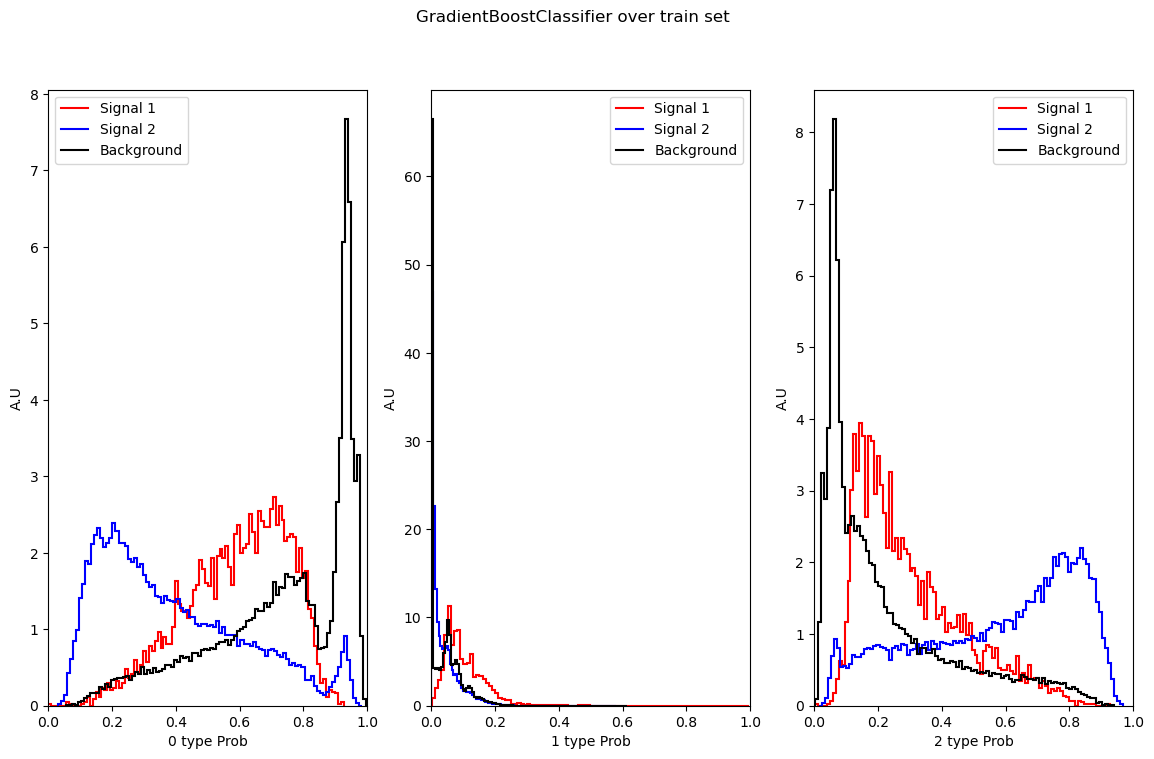

In [19]:
plt.figure(1, figsize=(14,8))
plt.subplot(1, 3, 1)
rml.plot("GBC_Prob_bkg", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("GBC_Prob_bkg", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("GBC_Prob_bkg", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"0 type Prob")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 2)
rml.plot("GBC_Prob_Dsst", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("GBC_Prob_Dsst", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("GBC_Prob_Dsst", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"1 type Prob")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 3)
rml.plot("GBC_Prob_Ds1", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("GBC_Prob_Ds1", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("GBC_Prob_Ds1", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"2 type Prob")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.suptitle("GradientBoostClassifier over train set")
plt.savefig("Graphs/Comp_DsgL_GBC_output_train_base_OvA.pdf", dpi=300, bbox_inches='tight')

Text(0.5, 0.98, 'RandomForestClassifier over train set')

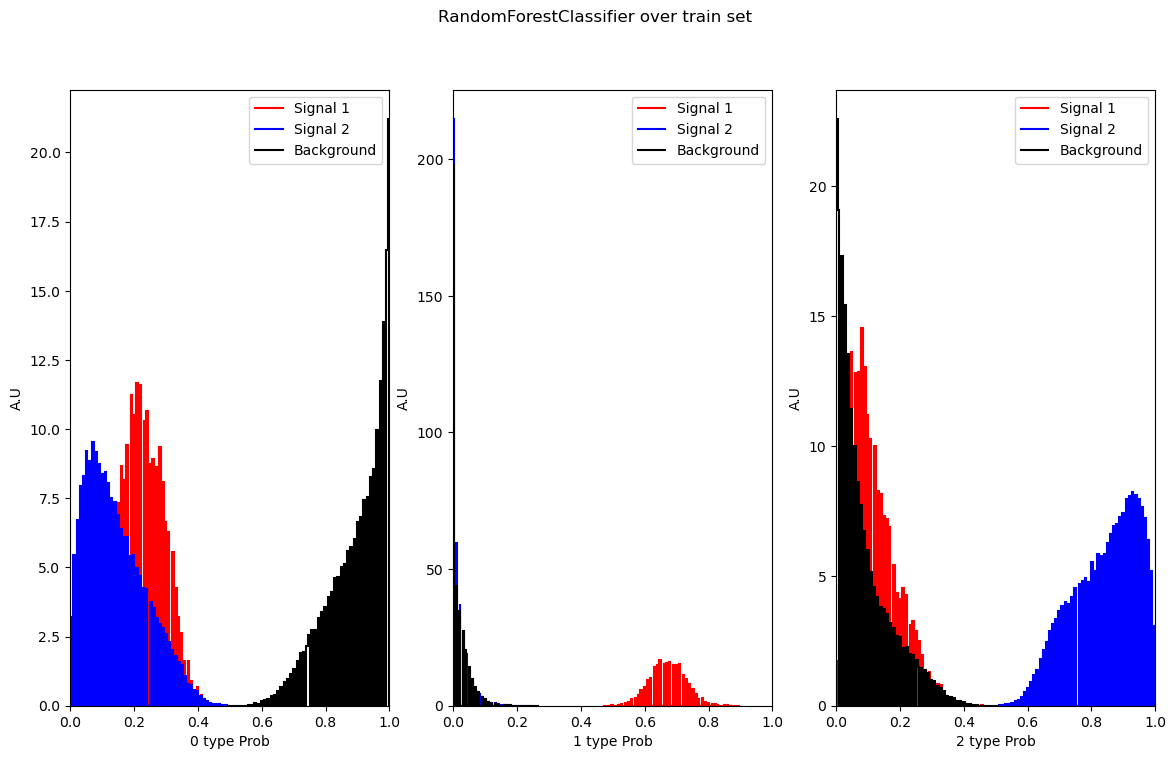

In [20]:
plt.figure(2, figsize=(14,8))
plt.subplot(1, 3, 1)
rml.plot("RFC_Prob_bkg", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("RFC_Prob_bkg", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("RFC_Prob_bkg", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"0 type Prob")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 2)
rml.plot("RFC_Prob_Dsst", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("RFC_Prob_Dsst", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("RFC_Prob_Dsst", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"1 type Prob")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.subplot(1, 3, 3)
rml.plot("RFC_Prob_Ds1", df_sig_1, label="Signal 1", color="r", density=True)
rml.plot("RFC_Prob_Ds1", df_sig_2, label="Signal 2", color="b", density=True)
rml.plot("RFC_Prob_Ds1", df_bkg, label="Background", color="k", density=True)
#rml.plot("GBC", df_train_shuf, label="All training", color="g", density=True)
plt.xlabel(r"2 type Prob")
plt.ylabel(r"A.U")
plt.xlim(0.0, 1.0)
plt.legend()
plt.suptitle("RandomForestClassifier over train set")

#### $M(D_s^+\gamma)$ BDT cut try

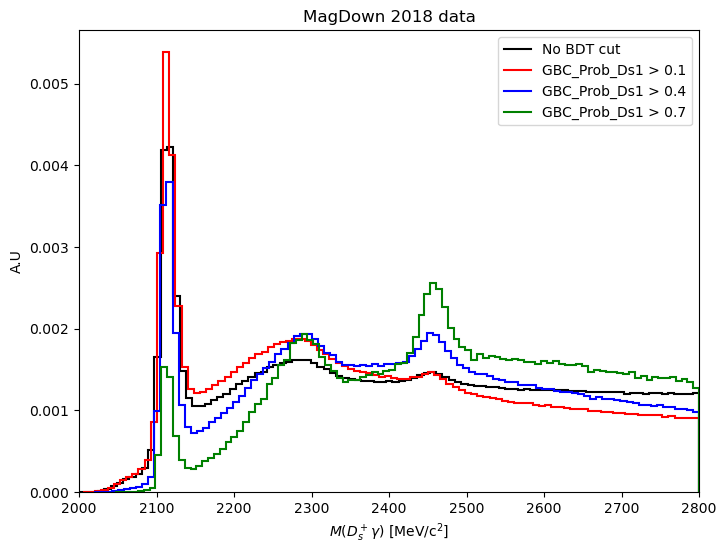

In [21]:
df_data_2 = df_data.query("DsgM < 2800")
df_data_GBC_cut = [df_data_2.query("GBC_Prob_Ds1 > {0}".format(i*0.3+0.1)) for i in range(3)] 
df_data_RFC_cut = df_data_2.query("RFC_Prob_bkg < 0.5")
df_data_pt_cut = df_data_2.query("gamma_PT < 1200")

colors = ["red", "blue", "green"]
plt.figure(1, figsize=(8,6))
rml.plot("DsgM", df_data_2, label="No BDT cut", color="k", density=True)
for i in range(3):
    rml.plot("DsgM", df_data_GBC_cut[i], label="GBC_Prob_Ds1 > {0}".format(i*0.3+0.1), color=colors[i], density=True)
#rml.plot("DsgM", df_data_RFC_cut, label="RFC_Prob_bkg < 0.5", color="r", density=True)
plt.xlabel(r"$M(D_s^+\gamma)$ $\mathrm{[MeV/c^2]} $")
plt.ylabel(r'A.U')
plt.xlim(2000, 2800)
plt.title(r'MagDown 2018 data')
plt.legend()
plt.savefig("Graphs/Exp_MagD18_DsgL_mass_BDT_cuts_base_OvA.pdf", dpi=300, bbox_inches='tight')

### Feature Importance

Text(0.5, 1.0, 'RFC classifier')

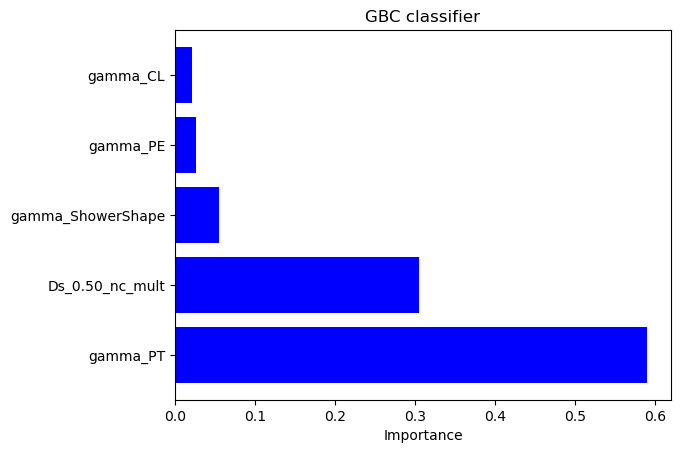

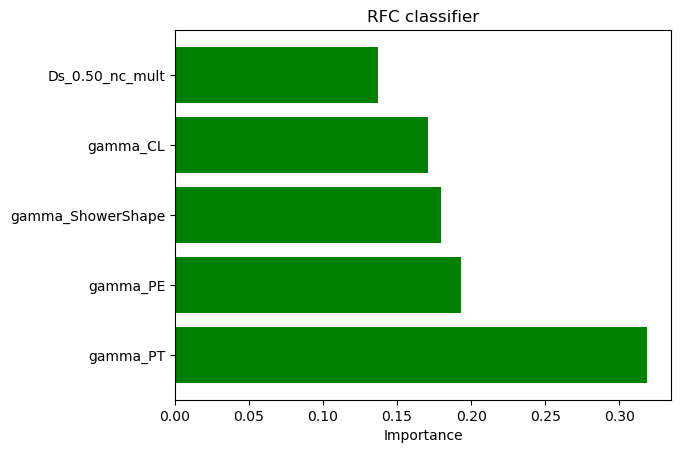

In [22]:
plt.figure(1)
rml.feature_importance_plot(gbc, base_features, color="blue")
plt.title("GBC classifier")
plt.savefig("Graphs/Comp_DsgL_GBC_feature_importance_base_OvA.pdf", dpi=300, bbox_inches='tight')

plt.figure(2)
rml.feature_importance_plot(rfc, base_features, color="green")
plt.title("RFC classifier")

#if base:
#    plt.savefig("Train_plots/Comp_Dspi0L_ADA_feature_importance_base.pdf", dpi=300, bbox_inches='tight')
#else:
#    plt.savefig("Train_plots/Comp_Dspi0L_ADA_feature_importance_all.pdf", dpi=300, bbox_inches='tight')

### Training performance


#### Confusion matrix

In [23]:
df_train_shuf["GBC type pred"] = gbc.predict(df_train_shuf[base_features])
df_train_shuf["RFC type pred"] = rfc.predict(df_train_shuf[base_features])

conf_gbc = confusion_matrix(df_train_shuf["type"], df_train_shuf["GBC type pred"])
conf_rfc = confusion_matrix(df_train_shuf["type"], df_train_shuf["RFC type pred"])

print("Confusion matrix for gbc algorithm")
print(conf_gbc)

print("Confusion matrix for rfc algorithm")
print(conf_rfc)

Confusion matrix for gbc algorithm
[[56966     3  9760]
 [ 3781    27   901]
 [12786     7 25833]]
Confusion matrix for rfc algorithm
[[66728     0     1]
 [    0  4709     0]
 [    0     0 38626]]


#### ROC curve

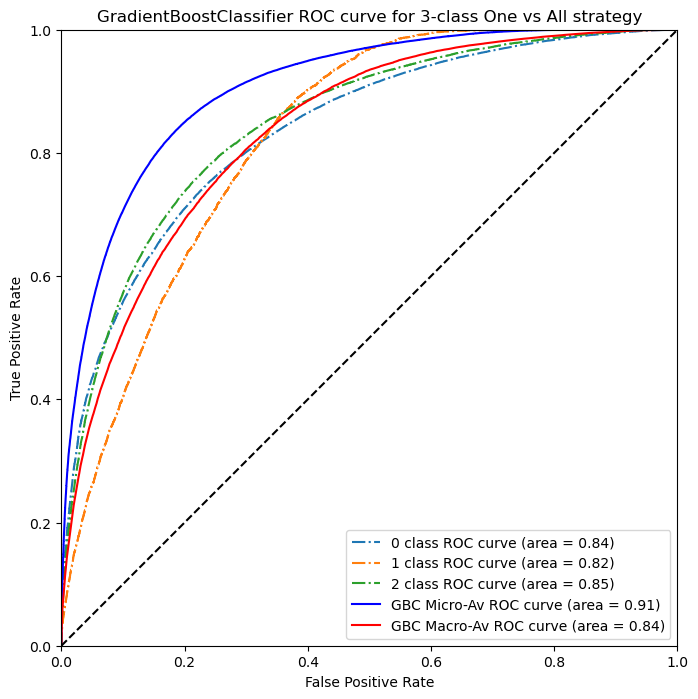

In [24]:
plt.figure(1, figsize=(10, 8))
rml.roc_curve_plot(gbc, df_train_shuf, base_features, "type",
               color="blue", label="GBC")
plt.legend()
plt.title("GradientBoostClassifier ROC curve for 3-class One vs All strategy")
plt.savefig("Graphs/Comp_DsgL_BDT_roc_curve_base_OvA.pdf", dpi=300, bbox_inches='tight')